# Esta notebook se autodestruirá al finalizarla

## Inicializacion

In [33]:
# limpio la memoria
Sys.time()
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

[1] "2025-11-24 01:27:24 UTC"

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1962148,104.8,3452986,184.5,5705064,304.7
Vcells,1091686515,8329.0,21816669142,166448.0,23293696145,177716.8


In [2]:
PARAM <- list()
PARAM$experimento <- "zmuerte-202109"
PARAM$semilla_primigenia <- 878787 #mi semilla me hizo ganar

In [3]:
setwd("/content/buckets/b1/exp/Workflow")
experimento_folder <- PARAM$experimento
dir.create(experimento_folder, showWarnings=FALSE)
setwd( paste0("/content/buckets/b1/exp/Workflow", experimento_folder ))

ERROR: Error in setwd(paste0("/content/buckets/b1/exp/Workflow", experimento_folder)): cannot change working directory


## Preprocesamiento

### Generacion de la clase_ternaria

In [4]:
Sys.time()
require( "data.table" )

# leo el dataset
require("data.table")

# Leer df2 normalmente
df2 <- fread("~/buckets/b1/datasets/competencia_02_crudo.csv.gz")

# Leer df3 como texto
df3 <- fread(
  "~/buckets/b1/datasets/competencia_03_crudo.csv.gz",
  colClasses = "character"
)

# Normalizar columnas de df3 al tipo de df2
clases_df2 <- sapply(df2, class)

for(col in names(df3)) {
  if(col %in% names(clases_df2)) {
    if(clases_df2[[col]] == "integer") {
      df3[, (col) := as.integer(get(col))]
    } else if(clases_df2[[col]] == "numeric") {
      df3[, (col) := as.numeric(get(col))]
    }
  }
}

# Ordenar columnas
setcolorder(df3, names(df2))

# Concatenar
dataset <- rbindlist(list(df2, df3), use.names = TRUE)

# calculo el periodo0 consecutivo
dsimple <- dataset[, list(
  "pos" = .I,
  numero_de_cliente,
  periodo0 = as.integer(foto_mes/100)*12 +  foto_mes%%100 )
]


# ordeno
setorder( dsimple, numero_de_cliente, periodo0 )

# calculo topes
periodo_ultimo <- dsimple[, max(periodo0) ]
periodo_anteultimo <- periodo_ultimo - 1


# calculo los leads de orden 1 y 2
dsimple[, c("periodo1", "periodo2") :=
  shift(periodo0, n=1:2, fill=NA, type="lead"),  numero_de_cliente
]

# assign most common class values = "CONTINUA"
dsimple[ periodo0 < periodo_anteultimo, clase_ternaria := "CONTINUA" ]

# calculo BAJA+1
dsimple[ periodo0 < periodo_ultimo &
  ( is.na(periodo1) | periodo0 + 1 < periodo1 ),
  clase_ternaria := "BAJA+1"
]

# calculo BAJA+2
dsimple[ periodo0 < periodo_anteultimo & (periodo0+1 == periodo1 )
  & ( is.na(periodo2) | periodo0 + 2 < periodo2 ),
  clase_ternaria := "BAJA+2"
]

# pego el resultado en el dataset original y grabo
setorder( dsimple, pos )
dataset[, clase_ternaria := dsimple$clase_ternaria ]

rm(dsimple)
gc()
Sys.time()

[1] "2025-11-23 22:46:52 UTC"

Loading required package: data.table



,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,771123,41.2,3651242,195.0,5705064,304.7
Vcells,1297334768,9897.9,1758360992,13415.3,1445617477,11029.2


[1] "2025-11-23 22:47:34 UTC"

In [5]:
# Busco los features que tienen full_zero menos foto_mes y numero_de_cliente (preventivo)
numeric_cols <- names(dataset)[sapply(dataset, is.numeric)]
numeric_cols <- setdiff(numeric_cols, c("foto_mes", "numero_de_cliente"))

result_list <- list()

for(month in unique(dataset$foto_mes)) {
  month_data <- dataset[foto_mes == month, ..numeric_cols]
  
  # TODO CERO
  zero_cols <- numeric_cols[sapply(month_data, function(x) all(x == 0, na.rm = TRUE))]
  
  if(length(zero_cols) > 0) {
    result_list[[as.character(month)]] <- data.table(
      foto_mes = month,
      column_name = zero_cols
    )
  }
}

vars_full_zero <- rbindlist(result_list)
print(vars_full_zero)

# Aplico NULL 
for(month in unique(vars_full_zero$foto_mes)){
  vars_this_month <- vars_full_zero[foto_mes == month, column_name]
  
  dataset[foto_mes == month,
          (vars_this_month) := lapply(.SD, function(x) ifelse(x == 0, NA, x)),
          .SDcols = vars_this_month]
}

     foto_mes                column_name
        <int>                     <char>
  1:   201901                tmobile_app
  2:   201901            cmobile_app_trx
  3:   201902                tmobile_app
  4:   201902            cmobile_app_trx
  5:   201903                tmobile_app
 ---                                    
103:   202102   ctarjeta_visa_descuentos
104:   202102   mtarjeta_visa_descuentos
105:   202102 ctarjeta_master_descuentos
106:   202102 mtarjeta_master_descuentos
107:   202105           ccajas_depositos


In [6]:
dataset <- dataset[, !c("minversion2", "Visa_mfinanciacion_limite"), with = FALSE]

### Data drifting con rankeds, no quito las columnas originales

In [7]:
rank_separate_group <- function(dataset, columns, group_col = "foto_mes") {
  cat("Generando columnas *_ranked con ranking separado por signo y grupo temporal...\n")
  
  for(col in columns) {
    new_col <- paste0(col, "_ranked")
    
    # Inicializar columna en NA
    dataset[, (new_col) := NA_real_]
    
    # Ranking de POSITIVOS (ascendente)
    dataset[get(col) > 0, 
            (new_col) := frank(get(col), ties.method = "average"), 
            by = group_col]
    
    # Ranking de NEGATIVOS (ascendente por valor absoluto, luego * -1)
    dataset[get(col) < 0, 
            (new_col) := -frank(abs(get(col)), ties.method = "average"), 
            by = group_col]
    
    # CEROS: asignar 0
    dataset[get(col) == 0, (new_col) := 0.0]
    
    # NA: ya están como NA por defecto
  }
  
  invisible(dataset)
}

# Columnas monetarias
cols_monetarias <- c(
  "mrentabilidad", "mrentabilidad_annual", "mcomisiones", "mactivos_margen", "mpasivos_margen", 
  "mcuenta_corriente_adicional", "mcuenta_corriente", "mcaja_ahorro", "mcaja_ahorro_adicional", 
  "mcaja_ahorro_dolares", "mcuentas_saldo", "mautoservicio", "mtarjeta_visa_consumo", "mtarjeta_master_consumo", 
  "mprestamos_prendarios", "mprestamos_hipotecarios", "mplazo_fijo_dolares", 
  "mplazo_fijo_pesos", "minversion1_pesos", "minversion1_dolares", "mpayroll2", "mpayroll",
  "mcuenta_debitos_automaticos", "mttarjeta_visa_debitos_automaticos", "mttarjeta_master_debitos_automaticos", 
  "mpagodeservicios", "mpagomiscuentas", "mcajeros_propios_descuentos", "mtarjeta_visa_descuentos", 
  "mtarjeta_master_descuentos", "mcomisiones_mantenimiento", "mcomisiones_otras", "mforex_buy", "mforex_sell", 
  "mtransferencias_recibidas", "mtransferencias_emitidas", "mextraccion_autoservicio", "mcheques_depositados", 
  "mcheques_emitidos", "mcheques_depositados_rechazados", "mcheques_emitidos_rechazados", "matm", "matm_other", 
  "Master_mfinanciacion_limite", "Master_msaldototal", "Master_msaldopesos", "Master_msaldodolares", 
  "Master_mconsumospesos", "Master_mconsumosdolares", "Master_mlimitecompra", "Master_madelantopesos", 
  "Master_madelantodolares", "Master_mpagado", "Master_mpagospesos", "Master_mpagosdolares", 
  "Master_mconsumototal", "Master_mpagominimo", "Visa_msaldototal", 
  "Visa_msaldopesos", "Visa_msaldodolares", "Visa_mconsumospesos", "Visa_mconsumosdolares", 
  "Visa_mlimitecompra", "Visa_madelantopesos", "Visa_madelantodolares", "Visa_mpagado", "Visa_mpagospesos", 
  "Visa_mpagosdolares", "Visa_mconsumototal", "Visa_mpagominimo"
)

# Aplicación
rank_separate_group(dataset, cols_monetarias)

Generando columnas *_ranked con ranking separado por signo y grupo temporal...


### Popurrí de columnas nuevas

In [8]:
# el mes 1,2, ..12 , podria servir para detectar estacionalidad
dataset[, kmes := foto_mes %% 100]

# creo un ctr_quarter que tenga en cuenta cuando
# los clientes hace 3 menos meses que estan
# ya que seria injusto considerar las transacciones medidas en menor tiempo
dataset[, ctrx_quarter_normalizado := as.numeric(ctrx_quarter) ]
dataset[cliente_antiguedad == 1, ctrx_quarter_normalizado := ctrx_quarter * 5.0]
dataset[cliente_antiguedad == 2, ctrx_quarter_normalizado := ctrx_quarter * 2.0]
dataset[cliente_antiguedad == 3, ctrx_quarter_normalizado := ctrx_quarter * 1.2]

# variable extraida de una tesis de maestria de Irlanda, se perdió el link
dataset[, mpayroll_sobre_edad := mpayroll / cliente_edad]

Sys.time()

[1] "2025-11-23 22:48:17 UTC"

In [9]:
# Poder adquisitivo y finanzas
dataset[, x_margen_total := mactivos_margen + mpasivos_margen] # Entró en top 30
dataset[, x_pct_margen_activos := mactivos_margen / pmax(x_margen_total, 1)] # Entró en top 30
dataset[, x_pct_dolares := (mcaja_ahorro_dolares + mplazo_fijo_dolares + minversion1_dolares) / pmax(mcuentas_saldo + mplazo_fijo_pesos + mplazo_fijo_dolares, 1)] # Entró en top 30
dataset[, x_patrimonio_neto := 
  (mcuentas_saldo + 
   mcaja_ahorro + mcaja_ahorro_adicional + mcaja_ahorro_dolares +
   mcuenta_corriente + mcuenta_corriente_adicional +
   mplazo_fijo_pesos + mplazo_fijo_dolares +
   minversion1_pesos + minversion1_dolares)
  -
  (mprestamos_prendarios + mprestamos_hipotecarios +
   Master_msaldototal + Visa_msaldototal)]
dataset[, x_rentabilidad_por_producto := mrentabilidad / pmax(cproductos, 1)]
dataset[, x_liquidity_stress := (Master_delinquency + Visa_delinquency + mcomisiones_mantenimiento + mcomisiones_otras) / pmax(mcuentas_saldo, 1)]
# Patrones de uso TC
dataset[, x_trx_visa_por_cuenta := ctarjeta_visa_transacciones / pmax(ctarjeta_visa, 1)] # Entró en top 30
dataset[, x_ticket_visa := mtarjeta_visa_consumo / pmax(ctarjeta_visa_transacciones, 1)] # Entró en top 30
# Débitos automáticos
dataset[, x_debitos_auto_total := ccuenta_debitos_automaticos + ctarjeta_visa_debitos_automaticos + ctarjeta_master_debitos_automaticos] # Entró en top 30
dataset[, x_monto_debito_promedio := (mcuenta_debitos_automaticos + mttarjeta_visa_debitos_automaticos + mttarjeta_master_debitos_automaticos) / pmax(x_debitos_auto_total, 1)] # Entró en top 30
# Ciclo de vida del cliente
dataset[, x_quarter := ceiling(kmes / 3)]
dataset[, x_lifecycle_stage := cliente_antiguedad / pmax(cliente_edad * 12, 1)]
dataset[, x_product_complexity := (tcuentas + ctarjeta_visa + ctarjeta_master + cprestamos_personales + cprestamos_hipotecarios + cseguro_vida + cseguro_auto) / 7]
# Poder adquisitivo y comportamiento
#dataset[, x_wealthy_active := x_patrimonio_neto * log1p(x_engagement_score)]
dataset[, x_wealh_premium_behavior := x_patrimonio_neto * x_ticket_visa]
#dataset[, x_dollarized_engaged := x_pct_dolares * x_engagement_score]
dataset[, x_wealth_automated := x_patrimonio_neto * x_debitos_auto_total]
dataset[, x_dollar_visa_premium := x_pct_dolares * x_ticket_visa]
dataset[, x_dollar_visa_activity := x_pct_dolares * x_trx_visa_por_cuenta]
dataset[, x_visa_auto_premium := x_ticket_visa * x_monto_debito_promedio]
dataset[, x_auto_premium := x_debitos_auto_total * x_ticket_visa * x_pct_margen_activos]

In [10]:
# Ratios con mcuentas_saldo
dataset[, ratio_mpayroll_saldo := 
  ifelse(is.na(mcuentas_saldo) | mcuentas_saldo == 0, 
         NA_real_, 
         mpayroll / mcuentas_saldo)]

# Ratios con mrentabilidad_annual
dataset[, ratio_mrentabilidad_annual_mpayroll := 
  ifelse(is.na(mpayroll) | mpayroll == 0, 
         NA_real_, 
         mrentabilidad_annual / mpayroll)]

dataset[, ratio_mrentabilidad_annual_edad := 
  ifelse(is.na(cliente_edad) | cliente_edad == 0, 
         NA_real_, 
         mrentabilidad_annual / cliente_edad)]

# Ratios con Visa_mpagominimo
dataset[, ratio_Visa_mpagominimo_mpayroll := 
  ifelse(is.na(mpayroll) | mpayroll == 0, 
         NA_real_, 
         Visa_mpagominimo / mpayroll)]

### Tendencias todas True

In [11]:
if( !require("Rcpp")) install.packages("Rcpp", repos = "http://cran.us.r-project.org")
require("Rcpp")

Loading required package: Rcpp



In [12]:
# se calculan para los 6 meses previos el minimo, maximo y
#  tendencia calculada con cuadrados minimos
# la formula de calculo de la tendencia puede verse en
#  https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/10%3A_Correlation_and_Regression/10.04%3A_The_Least_Squares_Regression_Line
# para la maxíma velocidad esta funcion esta escrita en lenguaje C,
# y no en la porqueria de R o Python

cppFunction("NumericVector fhistC(NumericVector pcolumna, IntegerVector pdesde )
{
  /* Aqui se cargan los valores para la regresion */
  double  x[100] ;
  double  y[100] ;

  int n = pcolumna.size();
  NumericVector out( 5*n );

  for(int i = 0; i < n; i++)
  {
    //lag
    if( pdesde[i]-1 < i )  out[ i + 4*n ]  =  pcolumna[i-1] ;
    else                   out[ i + 4*n ]  =  NA_REAL ;


    int  libre    = 0 ;
    int  xvalor   = 1 ;

    for( int j= pdesde[i]-1;  j<=i; j++ )
    {
       double a = pcolumna[j] ;

       if( !R_IsNA( a ) )
       {
          y[ libre ]= a ;
          x[ libre ]= xvalor ;
          libre++ ;
       }

       xvalor++ ;
    }

    /* Si hay al menos dos valores */
    if( libre > 1 )
    {
      double  xsum  = x[0] ;
      double  ysum  = y[0] ;
      double  xysum = xsum * ysum ;
      double  xxsum = xsum * xsum ;
      double  vmin  = y[0] ;
      double  vmax  = y[0] ;

      for( int h=1; h<libre; h++)
      {
        xsum  += x[h] ;
        ysum  += y[h] ;
        xysum += x[h]*y[h] ;
        xxsum += x[h]*x[h] ;

        if( y[h] < vmin )  vmin = y[h] ;
        if( y[h] > vmax )  vmax = y[h] ;
      }

      out[ i ]  =  (libre*xysum - xsum*ysum)/(libre*xxsum -xsum*xsum) ;
      out[ i + n ]    =  vmin ;
      out[ i + 2*n ]  =  vmax ;
      out[ i + 3*n ]  =  ysum / libre ;
    }
    else
    {
      out[ i       ]  =  NA_REAL ;
      out[ i + n   ]  =  NA_REAL ;
      out[ i + 2*n ]  =  NA_REAL ;
      out[ i + 3*n ]  =  NA_REAL ;
    }
  }

  return  out;
}")

In [13]:
# calcula la tendencia de las variables cols de los ultimos 6 meses
# la tendencia es la pendiente de la recta que ajusta por cuadrados minimos
# La funcionalidad de ratioavg es autoria de  Daiana Sparta,  UAustral  2021

TendenciaYmuchomas <- function(
    dataset, cols, ventana = 6, tendencia = TRUE,
    minimo = TRUE, maximo = TRUE, promedio = TRUE,
    ratioavg = TRUE, ratiomax = TRUE) {
  gc(verbose= FALSE)
  # Esta es la cantidad de meses que utilizo para la historia
  ventana_regresion <- ventana

  last <- nrow(dataset)

  # creo el vector_desde que indica cada ventana
  # de esta forma se acelera el procesamiento ya que lo hago una sola vez
  vector_ids <- dataset[ , numero_de_cliente ]

  vector_desde <- seq(
    -ventana_regresion + 2,
    nrow(dataset) - ventana_regresion + 1
  )

  vector_desde[1:ventana_regresion] <- 1

  for (i in 2:last) {
    if (vector_ids[i - 1] != vector_ids[i]) {
      vector_desde[i] <- i
    }
  }
  for (i in 2:last) {
    if (vector_desde[i] < vector_desde[i - 1]) {
      vector_desde[i] <- vector_desde[i - 1]
    }
  }

  for (campo in cols) {
    nueva_col <- fhistC(dataset[, get(campo)], vector_desde)

    if (tendencia) {
      dataset[, paste0(campo, "_tend", ventana) :=
        nueva_col[(0 * last + 1):(1 * last)]]
    }

    if (minimo) {
      dataset[, paste0(campo, "_min", ventana) :=
        nueva_col[(1 * last + 1):(2 * last)]]
    }

    if (maximo) {
      dataset[, paste0(campo, "_max", ventana) :=
        nueva_col[(2 * last + 1):(3 * last)]]
    }

    if (promedio) {
      dataset[, paste0(campo, "_avg", ventana) :=
        nueva_col[(3 * last + 1):(4 * last)]]
    }

    if (ratioavg) {
      dataset[, paste0(campo, "_ratioavg", ventana) :=
        get(campo) / nueva_col[(3 * last + 1):(4 * last)]]
    }

    if (ratiomax) {
      dataset[, paste0(campo, "_ratiomax", ventana) :=
        get(campo) / nueva_col[(2 * last + 1):(3 * last)]]
    }
  }
}

In [14]:
# Feature Engineering Historico
# Creacion de LAGs
setorder(dataset, numero_de_cliente, foto_mes)

# todo es lagueable, menos la primary key y la clase
cols_lagueables <- copy( setdiff(
  colnames(dataset),
  c("numero_de_cliente", "foto_mes", "clase_ternaria")
))

# https://rdrr.io/cran/data.table/man/shift.html

# lags de orden 1
dataset[,
  paste0(cols_lagueables, "_lag1") := shift(.SD, 1, NA, "lag"),
  by= numero_de_cliente,
  .SDcols= cols_lagueables
]

# lags de orden 2
dataset[,
  paste0(cols_lagueables, "_lag2") := shift(.SD, 2, NA, "lag"),
  by= numero_de_cliente,
  .SDcols= cols_lagueables
]

# agrego los delta lags
for (vcol in cols_lagueables)
{
  dataset[, paste0(vcol, "_delta1") := get(vcol) - get(paste0(vcol, "_lag1"))]
  dataset[, paste0(vcol, "_delta2") := get(vcol) - get(paste0(vcol, "_lag2"))]
}

Sys.time()

[1] "2025-11-23 22:51:47 UTC"

In [15]:
# parametros de Feature Engineering Historico de Tendencias
PARAM$FE_hist$Tendencias$run <- TRUE
PARAM$FE_hist$Tendencias$ventana <- 6
PARAM$FE_hist$Tendencias$tendencia <- TRUE
PARAM$FE_hist$Tendencias$minimo <- TRUE
PARAM$FE_hist$Tendencias$maximo <- TRUE
PARAM$FE_hist$Tendencias$promedio <- TRUE
PARAM$FE_hist$Tendencias$ratioavg <- TRUE
PARAM$FE_hist$Tendencias$ratiomax <- TRUE

In [16]:
# aqui se agregan las tendencias de los ultimos 6 meses

setorder(dataset, numero_de_cliente, foto_mes)

if( PARAM$FE_hist$Tendencias$run) {
    TendenciaYmuchomas(dataset,
    cols = cols_lagueables,
    ventana = PARAM$FE_hist$Tendencias$ventana, # 6 meses de historia
    tendencia = PARAM$FE_hist$Tendencias$tendencia,
    minimo = PARAM$FE_hist$Tendencias$minimo,
    maximo = PARAM$FE_hist$Tendencias$maximo,
    promedio = PARAM$FE_hist$Tendencias$promedio,
    ratioavg = PARAM$FE_hist$Tendencias$ratioavg,
    ratiomax = PARAM$FE_hist$Tendencias$ratiomax
  )
}

ncol(dataset)
Sys.time()

[1] 2202

[1] "2025-11-23 22:55:47 UTC"

### Random Forest

In [17]:
AgregaVarRandomForest <- function() {

  cat( "inicio AgregaVarRandomForest()\n")
  gc(verbose= FALSE)
  dataset[, clase01 := 0L ]
  dataset[ clase_ternaria %in% c( "BAJA+2", "BAJA+1"),
      clase01 := 1L ]

  campos_buenos <- setdiff(
    colnames(dataset),
    c( "clase_ternaria", "clase01")
  )

  dataset[, entrenamiento :=
    as.integer( foto_mes %in% PARAM$FE_rf$train$training )]

  dtrain <- lgb.Dataset(
    data = data.matrix(dataset[entrenamiento == TRUE, campos_buenos, with = FALSE]),
    label = dataset[entrenamiento == TRUE, clase01],
    free_raw_data = FALSE
  )

  modelo <- lgb.train(
     data = dtrain,
     param = PARAM$FE_rf$lgb_param,
     verbose = -100
  )

  cat( "Fin construccion RandomForest\n" )
  # grabo el modelo, achivo .model
  lgb.save(modelo, file="modelo.model" )

  qarbolitos <- copy(PARAM$FE_rf$lgb_param$num_iterations)

  periodos <- dataset[ , unique( foto_mes ) ]

  for( periodo in  periodos )
  {
    cat( "periodo = ", periodo, "\n" )
    datamatrix <- data.matrix(dataset[ foto_mes== periodo, campos_buenos, with = FALSE])

    cat( "Inicio prediccion\n" )
    prediccion <- predict(
        modelo,
        datamatrix,
        type = "leaf"
    )
    cat( "Fin prediccion\n" )

    for( arbolito in 1:qarbolitos )
    {
       cat( arbolito, " " )
       hojas_arbol <- unique(prediccion[ , arbolito])

       for (pos in 1:length(hojas_arbol)) {
         # el numero de nodo de la hoja, estan salteados
         nodo_id <- hojas_arbol[pos]
         dataset[ foto_mes== periodo, paste0(
            "rf_", sprintf("%03d", arbolito),
             "_", sprintf("%03d", nodo_id)
          ) :=  as.integer( nodo_id == prediccion[ , arbolito]) ]

       }

       rm( hojas_arbol )
    }
    cat( "\n" )

    rm( prediccion )
    rm( datamatrix )
    gc(verbose= FALSE)
  }

  gc(verbose= FALSE)

  # borro clase01 , no debe ensuciar el dataset
  dataset[ , clase01 := NULL ]

}

In [18]:
# Parametros de Feature Engineering  a partir de hojas de Random Forest

# Estos CUATRO parametros son los que se deben modificar
PARAM$FE_rf$arbolitos= 20
PARAM$FE_rf$hojas_por_arbol= 16
PARAM$FE_rf$datos_por_hoja= 100
PARAM$FE_rf$mtry_ratio= 0.2

# Estos son quasi fijos
PARAM$FE_rf$train$training <- c( 202103, 202104, 202105, 202106)

# Estos TAMBIEN son quasi fijos
PARAM$FE_rf$lgb_param <-list(
    # parametros que se pueden cambiar
    num_iterations = PARAM$FE_rf$arbolitos,
    num_leaves  = PARAM$FE_rf$hojas_por_arbol,
    min_data_in_leaf = PARAM$FE_rf$datos_por_hoja,
    feature_fraction_bynode  = PARAM$FE_rf$mtry_ratio,

    # para que LightGBM emule Random Forest
    boosting = "rf",
    bagging_fraction = ( 1.0 - 1.0/exp(1.0) ),
    bagging_freq = 1.0,
    feature_fraction = 1.0,

    # genericos de LightGBM
    max_bin = 31L,
    objective = "binary",
    first_metric_only = TRUE,
    boost_from_average = TRUE,
    feature_pre_filter = FALSE,
    force_row_wise = TRUE,
    verbosity = -100,
    max_depth = -1L,
    min_gain_to_split = 0.0,
    min_sum_hessian_in_leaf = 0.001,
    lambda_l1 = 0.0,
    lambda_l2 = 0.0,

    pos_bagging_fraction = 1.0,
    neg_bagging_fraction = 1.0,
    is_unbalance = FALSE,
    scale_pos_weight = 1.0,

    drop_rate = 0.1,
    max_drop = 50,
    skip_drop = 0.5,

    extra_trees = FALSE
  )

## Produccion

In [19]:
# training y future
Sys.time()

PARAM$train_final$meses <- c(201901, 201902, 201903, 201904, 201905, 201906,
    201907, 201908, 201909, 201910, 201911, 201912,
    202001, 202002, 202003, 202004, 202005, 202006,
    202007, 202008, 202009, 202010, 202011, 202012,
    202101, 202102, 202103, 202104,202105,202106,202107)
PARAM$train_final$undersampling <- 0.10

PARAM$future <- c(202109)

[1] "2025-11-23 22:55:47 UTC"

### Final Training Strategy

In [20]:
# se filtran los meses donde se entrena el modelo final
dataset_train_final <- dataset[foto_mes %in% PARAM$train_final$meses]

In [21]:
# Undersampling, van todos los "BAJA+1" y "BAJA+2" y solo algunos "CONTINIA"

set.seed(PARAM$semilla_primigenia, kind = "L'Ecuyer-CMRG")
dataset_train_final[, azar := runif(nrow(dataset_train_final))]
dataset_train_final[, training := 0L]

dataset_train_final[
  (azar <= PARAM$train_final$undersampling | clase_ternaria %in% c("BAJA+1", "BAJA+2")),
  training := 1L
]

dataset_train_final[, azar:= NULL] # elimino la columna azar

### Target Engineering

In [22]:
# paso la clase a binaria que tome valores {0,1}  enteros
#  BAJA+1 y BAJA+2  son  1,   CONTINUA es 0
#  a partir de ahora ya NO puedo cortar  por prob(BAJA+2) > 1/40

dataset_train_final[,
  clase01 := ifelse(clase_ternaria %in% c("BAJA+2","BAJA+1"), 1L, 0L)
]

### Final Model

In [23]:
# utilizo  zLightGBM  la nueva libreria
if( !require("zlightgbm") ) install.packages("https://storage.googleapis.com/open-courses/dmeyf2025-e4a2/zlightgbm_4.6.0.99.tar.gz", repos= NULL, type= "source")
require("zlightgbm")
Sys.time()

Loading required package: zlightgbm

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘zlightgbm’”
Installing package into ‘/home/josefina_gayoso/.local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: zlightgbm



[1] "2025-11-23 22:57:48 UTC"

Un hiperparámetro de  *zLightGBM* es la cantidad de canaritos, en este caso se decidió (con tests realizados en {202101, 202102} fijarlo en 50
<br> esta es una importante decisión que debe tomarse
<br> en la version actual de *zLightGBM* los canaritos deben agregarse por fuera al dataset, y mandatoriamente deben ser las primeras columnas del mismo
<br> durante noviembre, si hay suerte, se liberará una versiónn que lo haga automáticamente internamente en el código C++ de la librería

In [24]:
# canaritos
PARAM$qcanaritos <- 5

cols0 <- copy(colnames(dataset_train_final))
filas <- nrow(dataset_train_final)

for( i in seq(PARAM$qcanaritos) ){
  dataset_train_final[, paste0("canarito_",i) := runif( filas) ]
}

# las columnas canaritos mandatoriamente van al comienzo del dataset
cols_canaritos <- copy( setdiff( colnames(dataset_train_final), cols0 ) )
setcolorder( dataset_train_final, c( cols_canaritos, cols0 ) )

Sys.time()

[1] "2025-11-23 22:57:49 UTC"

In [25]:
# los campos que se van a utilizar

campos_buenos <- setdiff(
  colnames(dataset_train_final),
  c("clase_ternaria", "clase01", "training")
)

In [26]:
# --- Función auxiliar para calcular diferencia en meses ---
meses_entre <- function(fecha1, fecha2) {
  12 * (as.numeric(format(fecha1, "%Y")) - as.numeric(format(fecha2, "%Y"))) +
       (as.numeric(format(fecha1, "%m")) - as.numeric(format(fecha2, "%m")))
}

# Convertir foto_mes a fecha real
to_year_month <- function(x) {
  as.Date(paste0(substr(x, 1, 4), "-", substr(x, 5, 6), "-01"))
}

dataset_train_final[, fecha := to_year_month(foto_mes)]

# Mes más reciente dentro del training
mes_mas_reciente_fecha <- dataset_train_final[training == 1L, max(fecha)]

# Diferencia REAL en meses (no días)
dataset_train_final[, meses_atras := meses_entre(mes_mas_reciente_fecha, fecha)]

# Aplicar decay
dataset_train_final[, peso := 0.95 ^ meses_atras]

# Mostrar pesos
cat("Pesos por mes:\n")
print(dataset_train_final[training == 1L, 
      .(peso = unique(peso)), 
      by = foto_mes][order(foto_mes)])

# Dataset final con pesos
dtrain_final <- lgb.Dataset(
  data = data.matrix(dataset_train_final[training == 1L, campos_buenos, with = FALSE]),
  label = dataset_train_final[training == 1L, clase01],
  weight = dataset_train_final[training == 1L, peso],
  free_raw_data = FALSE
)

cat("filas", nrow(dataset_train_final[training == 1L]), 
    "columnas", length(campos_buenos), "\n")

Pesos por mes:
    foto_mes      peso
       <int>     <num>
 1:   201901 0.2146388
 2:   201902 0.2259355
 3:   201903 0.2378269
 4:   201904 0.2503441
 5:   201905 0.2635201
 6:   201906 0.2773896
 7:   201907 0.2919890
 8:   201908 0.3073569
 9:   201909 0.3235335
10:   201910 0.3405616
11:   201911 0.3584859
12:   201912 0.3773536
13:   202001 0.3972143
14:   202002 0.4181203
15:   202003 0.4401267
16:   202004 0.4632912
17:   202005 0.4876750
18:   202006 0.5133421
19:   202007 0.5403601
20:   202008 0.5688001
21:   202009 0.5987369
22:   202010 0.6302494
23:   202011 0.6634204
24:   202012 0.6983373
25:   202101 0.7350919
26:   202102 0.7737809
27:   202103 0.8145062
28:   202104 0.8573750
29:   202105 0.9025000
30:   202106 0.9500000
31:   202107 1.0000000
    foto_mes      peso
filas 491877 columnas 2206 


In [27]:
# definicion de parametros, los viejos y los nuevos

PARAM$lgbm <-  list(
  boosting= "gbdt",
  objective= "binary",
  metric= "custom",
  first_metric_only= FALSE,
  boost_from_average= TRUE,
  feature_pre_filter= FALSE,
  force_row_wise= TRUE,
  verbosity= -100,

  seed= PARAM$semilla_primigenia,

  max_bin= 31L,
  min_data_in_leaf= 20L,  #este ya es el valor default de LightGBM

  num_iterations= 9999L, # dejo libre la cantidad de arboles, zLightGBM se detiene solo
  num_leaves= 9999L, # dejo libre la cantidad de hojas, zLightGBM sabe cuando no hacer un split
  learning_rate= 1.0,  # se lo deja en 1.0 para que si el score esta por debajo de gradient_bound no se lo escale
    
  feature_fraction= 0.50, # un valor equilibrado, habra que probar alternativas ...
    
  canaritos= PARAM$qcanaritos, # fundamental en zLightGBM, aqui esta el control del overfitting
  gradient_bound= 0.1  # default de zLightGBM
)

Sys.time()

[1] "2025-11-23 22:58:40 UTC"

####  Entrenamiento del modelo

Aqui se ejecuta  *zLightGBM*
<br> no se utilizan hiperparámetros optimos para controlar el overfitting
<br> zLightGBM  sabe cuando no hacer un split
<br> si al hacer el n-simo arbol, no puede hacer el split de la raiz, detiene el crecimiento del ensemble y termina
<br>
<br> claramente el  min_data_in_leaf=20 que es el default de LightGBM esta jugando un papel importante

In [28]:
# entreno el modelo

modelo_final <- lgb.train(
  data= dtrain_final,
  param= PARAM$lgbm
)

Sys.time()

[1] "2025-11-24 01:09:05 UTC"

### Scoring

Se hace el predict() del modelo en los datos del futuro

In [29]:
# aplico el modelo a los datos sin clase
dfuture <- dataset[foto_mes %in% PARAM$future]

# penosamente, en la versión actual de zLightGBM  los campos canaritos
#  aunque no se utilizan para nada, también deben estar en el dataset donde se hace el predict()
filas <- nrow(dfuture)

for( i in seq(PARAM$qcanaritos) ){
  dfuture[, paste0("canarito_",i) := runif( filas) ]
}

prediccion <- predict(
  modelo_final,
  data.matrix(dfuture[, campos_buenos, with= FALSE]),
)

In [30]:
# tabla de prediccion, puede ser util para futuros ensembles
#  ya que le modelo ganador va a ser un ensemble de LightGBMs

tb_prediccion <- dfuture[, list(numero_de_cliente, foto_mes)]
tb_prediccion[, prob := prediccion ]

# grabo las probabilidad del modelo
fwrite(tb_prediccion,
  file= "prediccion.txt",
  sep= "\t"
)

In [31]:
tb_prediccion

numero_de_cliente,foto_mes,prob
<int>,<int>,<dbl>
249221323,202109,3.866867e-09
249227600,202109,8.835383e-09
249234235,202109,5.391240e-05
249244449,202109,3.094560e-09
249244739,202109,8.962729e-09
249255456,202109,3.345598e-09
249255747,202109,3.499288e-08
249257429,202109,6.867191e-08
249273979,202109,3.638909e-09


In [30]:
if(!require("ggplot2")) install.packages("ggplot2")
require("ggplot2")

Loading required package: ggplot2




📊 Resultados de ganancia:
   - Ganancia máxima: $ 411,940,000 
   - Envíos óptimos:  10843 
   - Probabilidad de corte:  0.0004286453 


[1] "2025-11-23 02:03:31 UTC"

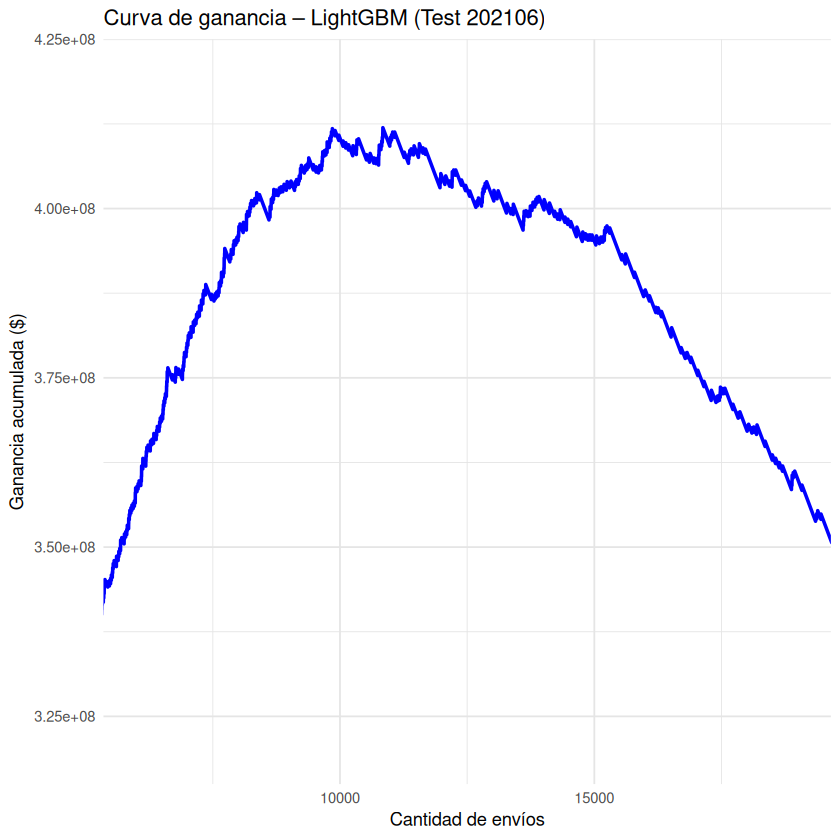

In [31]:
# ============================================================================
# CURVAS DE GANANCIA
# ============================================================================

# Filtrar datos del mes de test (futuro)
df_test <- dataset[foto_mes %in% PARAM$future]

# Agregar campo ganancia
df_test[, gan := ifelse(clase_ternaria == "BAJA+2", 780000.0, -20000.0)]

# Agregar canaritos (mismo que en predicción)
set.seed(PARAM$semilla_primigenia)
filas <- nrow(df_test)
for(i in seq(PARAM$qcanaritos)) {
  df_test[, paste0("canarito_", i) := runif(filas)]
}

# Predicción en test
X_test <- data.matrix(df_test[, campos_buenos, with = FALSE])
preds <- predict(modelo_final, X_test)

# Tabla con ganancia y probabilidad
tb <- data.table(
  gan = df_test$gan,
  prob = preds
)

# Ordenar por probabilidad descendente
setorder(tb, -prob)

# Calcular ganancia acumulada
tb[, gan_acum := cumsum(gan)]

# Gráfico de curva de ganancia
gan_acum <- tb$gan_acum
x <- 1:length(gan_acum)

ggplot(data.frame(x = x, gan_acum = gan_acum), aes(x = x, y = gan_acum)) +
  geom_line(linewidth = 1, color = "blue") +
  coord_cartesian(xlim = c(6000, 19000), ylim = c(320000000, 420000000)) +
  labs(
    x = "Cantidad de envíos",
    y = "Ganancia acumulada ($)",
    title = paste0("Curva de ganancia – LightGBM (Test ", PARAM$future[1], ")")
  ) +
  theme_minimal() +
  theme(panel.grid = element_line(color = "gray90"))

# Encontrar punto óptimo de corte
max_gan <- max(tb$gan_acum)
idx_max <- which.max(tb$gan_acum)

cat("\n📊 Resultados de ganancia:\n")
cat("   - Ganancia máxima: $", format(max_gan, big.mark=","), "\n")
cat("   - Envíos óptimos: ", idx_max, "\n")
cat("   - Probabilidad de corte: ", tb$prob[idx_max], "\n")

Sys.time()

### Clasificacion

Se tomó la decisión de enviar a los 11000 registros con mayor probabilidad de POS={"BAJA+1","BAJA+"}
<br> esto se determinó en forma artesanal analizando meses anterior
<br> esta es una muy importante decisión 

In [32]:
# genero archivos con los  "envios" mejores
dir.create("kaggle", showWarnings=FALSE)

# ordeno por probabilidad descendente
setorder(tb_prediccion, -prob)

envios <- 11000
tb_prediccion[, Predicted := 0L] # seteo inicial a 0
tb_prediccion[1:envios, Predicted := 1L] # marco los primeros

archivo_kaggle <- paste0("./kaggle/KA", PARAM$experimento, "_", envios, ".csv")

# grabo el archivo
fwrite(tb_prediccion[, list(numero_de_cliente, Predicted)],
  file= archivo_kaggle,
  sep= ","
)